In [11]:
import gym
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

from tqdm import tqdm
from PIL import Image

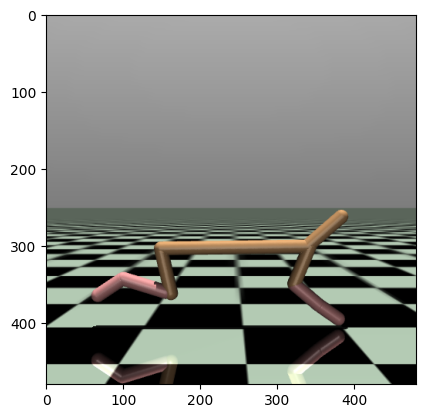

In [ ]:
# env = gym.make('HalfCheetah-v2', render_mode="rgb_array")
# env.reset()

# img = plt.imshow(env.render()) # only call this once

# for _ in range(10):
#     img.set_data(env.render()) # just update the data
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
#     action = env.action_space.sample()
#     env.step(action)
    
# env.close()

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.tensorboard import SummaryWriter
import gym

import matplotlib.pyplot as plt
import numpy as np

In [3]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action, hidden_dim=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Linear(hidden_dim, action_dim)
        self.max_action = max_action
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)
        log_std = self.log_std(x)
        log_std = torch.clamp(log_std, -20, 2)
        std = torch.exp(log_std)
        return mu, std
    
    def sample(self, state, deterministic=False):
        mu, std = self.forward(state)
        if deterministic:
            action = torch.tanh(mu)
            return action * self.max_action, None
        else:       
            normal = Normal(mu, std)
            x = normal.rsample()  # Reparameterization trick
            action = torch.tanh(x)
            log_prob = normal.log_prob(x) - torch.log(1 - action.pow(2) + 1e-6)
            log_prob = log_prob.sum(1, keepdim=True)
            return action * self.max_action, log_prob

# Q-networks
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()
        # Q1
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.q1 = nn.Linear(hidden_dim, 1)
        
        # Q2 (for reducing overestimation bias)
        self.fc3 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.q2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        
        # Q1
        q1 = F.relu(self.fc1(x))
        q1 = F.relu(self.fc2(q1))
        q1 = self.q1(q1)
        
        # Q2
        q2 = F.relu(self.fc3(x))
        q2 = F.relu(self.fc4(q2))
        q2 = self.q2(q2)
        
        return q1, q2

class SAC:
    def __init__(
        self, 
        state_dim, 
        action_dim, 
        max_action,
        alpha=0.2,
        gamma=0.99,
        tau=0.005,
        actor_lr=3e-4,
        critic_lr=3e-4,
        update_frequency=1,
        min_buffer_size=100,
        batch_size=64,
        buffer_size=10000
    ):
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha
        self.update_frequency = update_frequency
        self.min_buffer_size = min_buffer_size
        self.batch_size = batch_size
        
        # Initialize networks
        self.actor = Actor(state_dim, action_dim, max_action)
        self.critic = Critic(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)
        
        # Copy parameters
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        
        # Experience buffer for mini-batch updates
        self.buffer = []
        self.buffer_size = buffer_size
        self.total_steps = 0
        
    def select_action(self, state, deterministic=False):
        state = torch.FloatTensor(state.reshape(1, -1))
        action, _ = self.actor.sample(state, deterministic=deterministic)
        return action.detach().numpy().flatten()
    
    def update_parameters(self):
        if len(self.buffer) < self.min_buffer_size:
            return
            
        # Sample from buffer
        indices = np.random.choice(len(self.buffer), min(self.batch_size, len(self.buffer)))
        batch = [self.buffer[i] for i in indices]
        state, action, reward, next_state, done = zip(*batch)
        
        state = torch.FloatTensor(np.array(state))
        action = torch.FloatTensor(np.array(action))
        reward = torch.FloatTensor(np.array(reward).reshape(-1, 1))
        next_state = torch.FloatTensor(np.array(next_state))
        done = torch.FloatTensor(np.array(done).reshape(-1, 1))
        
        with torch.no_grad():
            # Sample next action and its log probability
            next_action, next_log_prob = self.actor.sample(next_state)
            
            # Target Q-values
            target_q1, target_q2 = self.critic_target(next_state, next_action)
            target_q = torch.min(target_q1, target_q2)
            target_q = reward + (1 - done) * self.gamma * (target_q - self.alpha * next_log_prob)
            
        # Current Q-values
        current_q1, current_q2 = self.critic(state, action)
        
        # Critic loss
        critic_loss = F.mse_loss(current_q1, target_q) + F.mse_loss(current_q2, target_q)
        
        # Update critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # Actor loss calculation
        new_action, log_prob = self.actor.sample(state)
        q1, q2 = self.critic(state, new_action)
        q = torch.min(q1, q2)
        actor_loss = (self.alpha * log_prob - q).mean()
        
        # Update actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Update target networks
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1 - self.tau))
    
    def store_transition(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        if len(self.buffer) > self.buffer_size:
            self.buffer.pop(0)
        
        self.total_steps += 1
        if self.total_steps % self.update_frequency == 0:
            self.update_parameters()

In [ ]:
# # Function to run an online learning episode
# def run_online_learning(env_name="HalfCheetah-v4", max_steps=1000000):
#     env = gym.make(env_name)
#     state_dim = env.observation_space.shape[0]
#     action_dim = env.action_space.shape[0]
#     max_action = float(env.action_space.high[0])
    
#     # Initialize the agent
#     agent = SAC(
#         state_dim=state_dim,
#         action_dim=action_dim,
#         max_action=max_action,
#         update_frequency=100,  # Update after each step for truly online learning
#         min_buffer_size=100  # Start learning after collecting 100 samples
#     )
    
#     # Initial state
#     state, _ = env.reset()
#     episode_reward = 0
    
#     # Logging variables
#     rewards = []
#     avg_speeds = []
#     current_speed_window = []
    
#     for step in range(max_steps):
#         # Select action
#         action = agent.select_action(state)
        
#         # Execute action
#         next_state, reward, terminated, truncated, _ = env.step(action)
#         done = terminated or truncated
        
#         # Store transition
#         agent.store_transition(state, action, reward, next_state, done)
        
#         # Update state and accumulate reward
#         state = next_state
#         episode_reward += reward
        
#         # Track speed (x-velocity is typically the relevant metric for half-cheetah)
#         current_speed_window.append(next_state[8])  # Assuming index 8 is x-velocity
#         if len(current_speed_window) > 100:
#             current_speed_window.pop(0)
        
#         # Log performance metrics every 100 steps
#         if step % 100 == 0:
#             rewards.append(episode_reward)
#             avg_speed = np.mean(current_speed_window) if current_speed_window else 0
#             avg_speeds.append(avg_speed)
#             print(f"Step: {step}, Avg. Reward: {episode_reward/(step+1):.2f}, Avg. Speed: {avg_speed:.2f}")
        
#         # Reset if episode ends (shouldn't happen in this case, but as a safeguard)
#         if done:
#             state, _ = env.reset()
            
#     return rewards, avg_speeds, agent

# if __name__ == "__main__":
#     rewards, speeds, agent = run_online_learning()

In [ ]:
def evaluate_policy(agent, env_name="HalfCheetah-v4", eval_episodes=10):
    eval_env = gym.make(env_name)
    avg_reward = 0.
    for _ in range(eval_episodes):
        state, _ = eval_env.reset()
        done = False
        while not done:
            action = agent.select_action(state, deterministic=True)
            state, reward, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
            avg_reward += reward
    avg_reward /= eval_episodes
    return avg_reward

def run_learning(env_name="HalfCheetah-v4", max_steps=1000000, eval_freq=5000):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    
    # Initialize the agent
    agent = SAC(
        state_dim=state_dim,
        action_dim=action_dim,
        max_action=max_action,
        update_frequency=1,  # Update after each step for truly online learning
        min_buffer_size=100  # Start learning after collecting 100 samples
    )
    
    # Initial state
    state, _ = env.reset()
    episode_reward = 0
    
    # Logging variables
    rewards = []
    avg_speeds = []
    current_speed_window = []
    evaluations = []

    writer = SummaryWriter(log_dir="runs/my_experiment")
    
    for step in range(max_steps):
        # Select action
        action = agent.select_action(state)
        
        # Execute action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # Store transition
        agent.store_transition(state, action, reward, next_state, done)
        
        # Update state and accumulate reward
        state = next_state
        episode_reward += reward
        
        # Track speed (x-velocity is typically the relevant metric for half-cheetah)
        current_speed_window.append(next_state[8])  # Assuming index 8 is x-velocity
        if len(current_speed_window) > 100:
            current_speed_window.pop(0)
        
        # Log performance metrics every 100 steps
        if step % 100 == 0:
            rewards.append(episode_reward)
            avg_speed = np.mean(current_speed_window) if current_speed_window else 0
            avg_speeds.append(avg_speed)
            # print(f"Step: {step}, Avg. Reward: {episode_reward/(step+1):.2f}, Avg. Speed: {avg_speed:.2f}")
        
        # Evaluate policy periodically
        if step % eval_freq == 0:
            avg_return = evaluate_policy(agent, env_name)
            evaluations.append(avg_return)
            print(f"Evaluation at step {step}: Avg. Return: {avg_return:.2f}")
            writer.add_scalar("Avg. Return", avg_return, step)
        
        # Reset if episode ends (shouldn't happen in this case, but as a safeguard)
        if done:
            state, _ = env.reset()

    writer.close()        
    return rewards, avg_speeds, evaluations, agent

if __name__ == "__main__":
    rewards, speeds, evaluations, agent = run_learning()

In [16]:
save_gif = True

env = gym.make('HalfCheetah-v2', render_mode="rgb_array")
state, _ = env.reset()

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

agent = Actor(state_dim, action_dim, max_action)
agent.load_state_dict(torch.load("online_sac_policy.pth"))

frames = []
    
for _ in range(100):
    frames.append(env.render())
    state = torch.FloatTensor(state.reshape(1, -1))
    action, _ = agent.sample(state, deterministic=True)
    action = action.detach().numpy().flatten()    
    
    next_state, reward, terminated, truncated, _ = env.step(action)
    state = next_state
    
env.close()

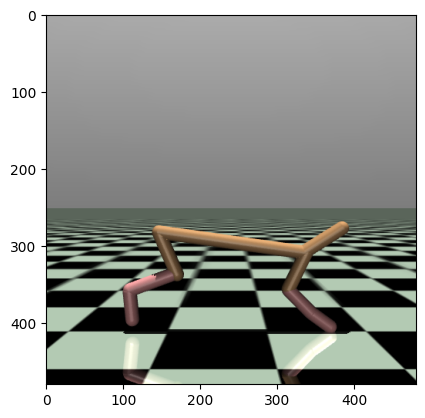

In [17]:
img = plt.imshow(frames[0])
for frame in frames[1:]:
    img.set_data(frame)
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [18]:
pil_frames = [Image.fromarray(frame) for frame in frames]
pil_frames[0].save("online_sac.gif", save_all=True, append_images=pil_frames[1:], duration=100, loop=0)